In [1]:
#import pandas, numpy, matplotlib and seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#import warning
import warnings
warnings.filterwarnings('ignore')

In [2]:
#improting wine dataset
dataset = pd.read_csv('./Dataset/WineQT.csv')

In [3]:
dataset.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


In [4]:
#drop id column because its unecessary
dataset = dataset.drop("Id",axis=1)

In [5]:
#checking duplicated values
print(dataset.duplicated().any())

#dropping duplicated rows
dataset.drop_duplicates(inplace=True)

#check again
print(dataset.duplicated().any())

True
False


In [6]:
#function to find Missing Value in every columns
def get_missing_value(df):
    mis_val = df.isnull().sum()
    tot_val = df.shape[0]
    mis_percentage = round((100 * mis_val / tot_val),2)
    miss_tab = pd.concat([mis_val, mis_percentage], axis=1)
    miss_tab_col_name = miss_tab.rename(columns = {0 : 'Row With Missing Value', 1 : 'Percentage (%)'})
    miss_tab_col_name = miss_tab_col_name.sort_values('Percentage (%)',ascending=False)
    return miss_tab_col_name

#checking missing value
get_missing_value(dataset)

,Row With Missing Value,Percentage (%)
fixed acidity,0,0.0
volatile acidity,0,0.0
citric acid,0,0.0
residual sugar,0,0.0
chlorides,0,0.0
free sulfur dioxide,0,0.0
total sulfur dioxide,0,0.0
density,0,0.0
pH,0,0.0
sulphates,0,0.0


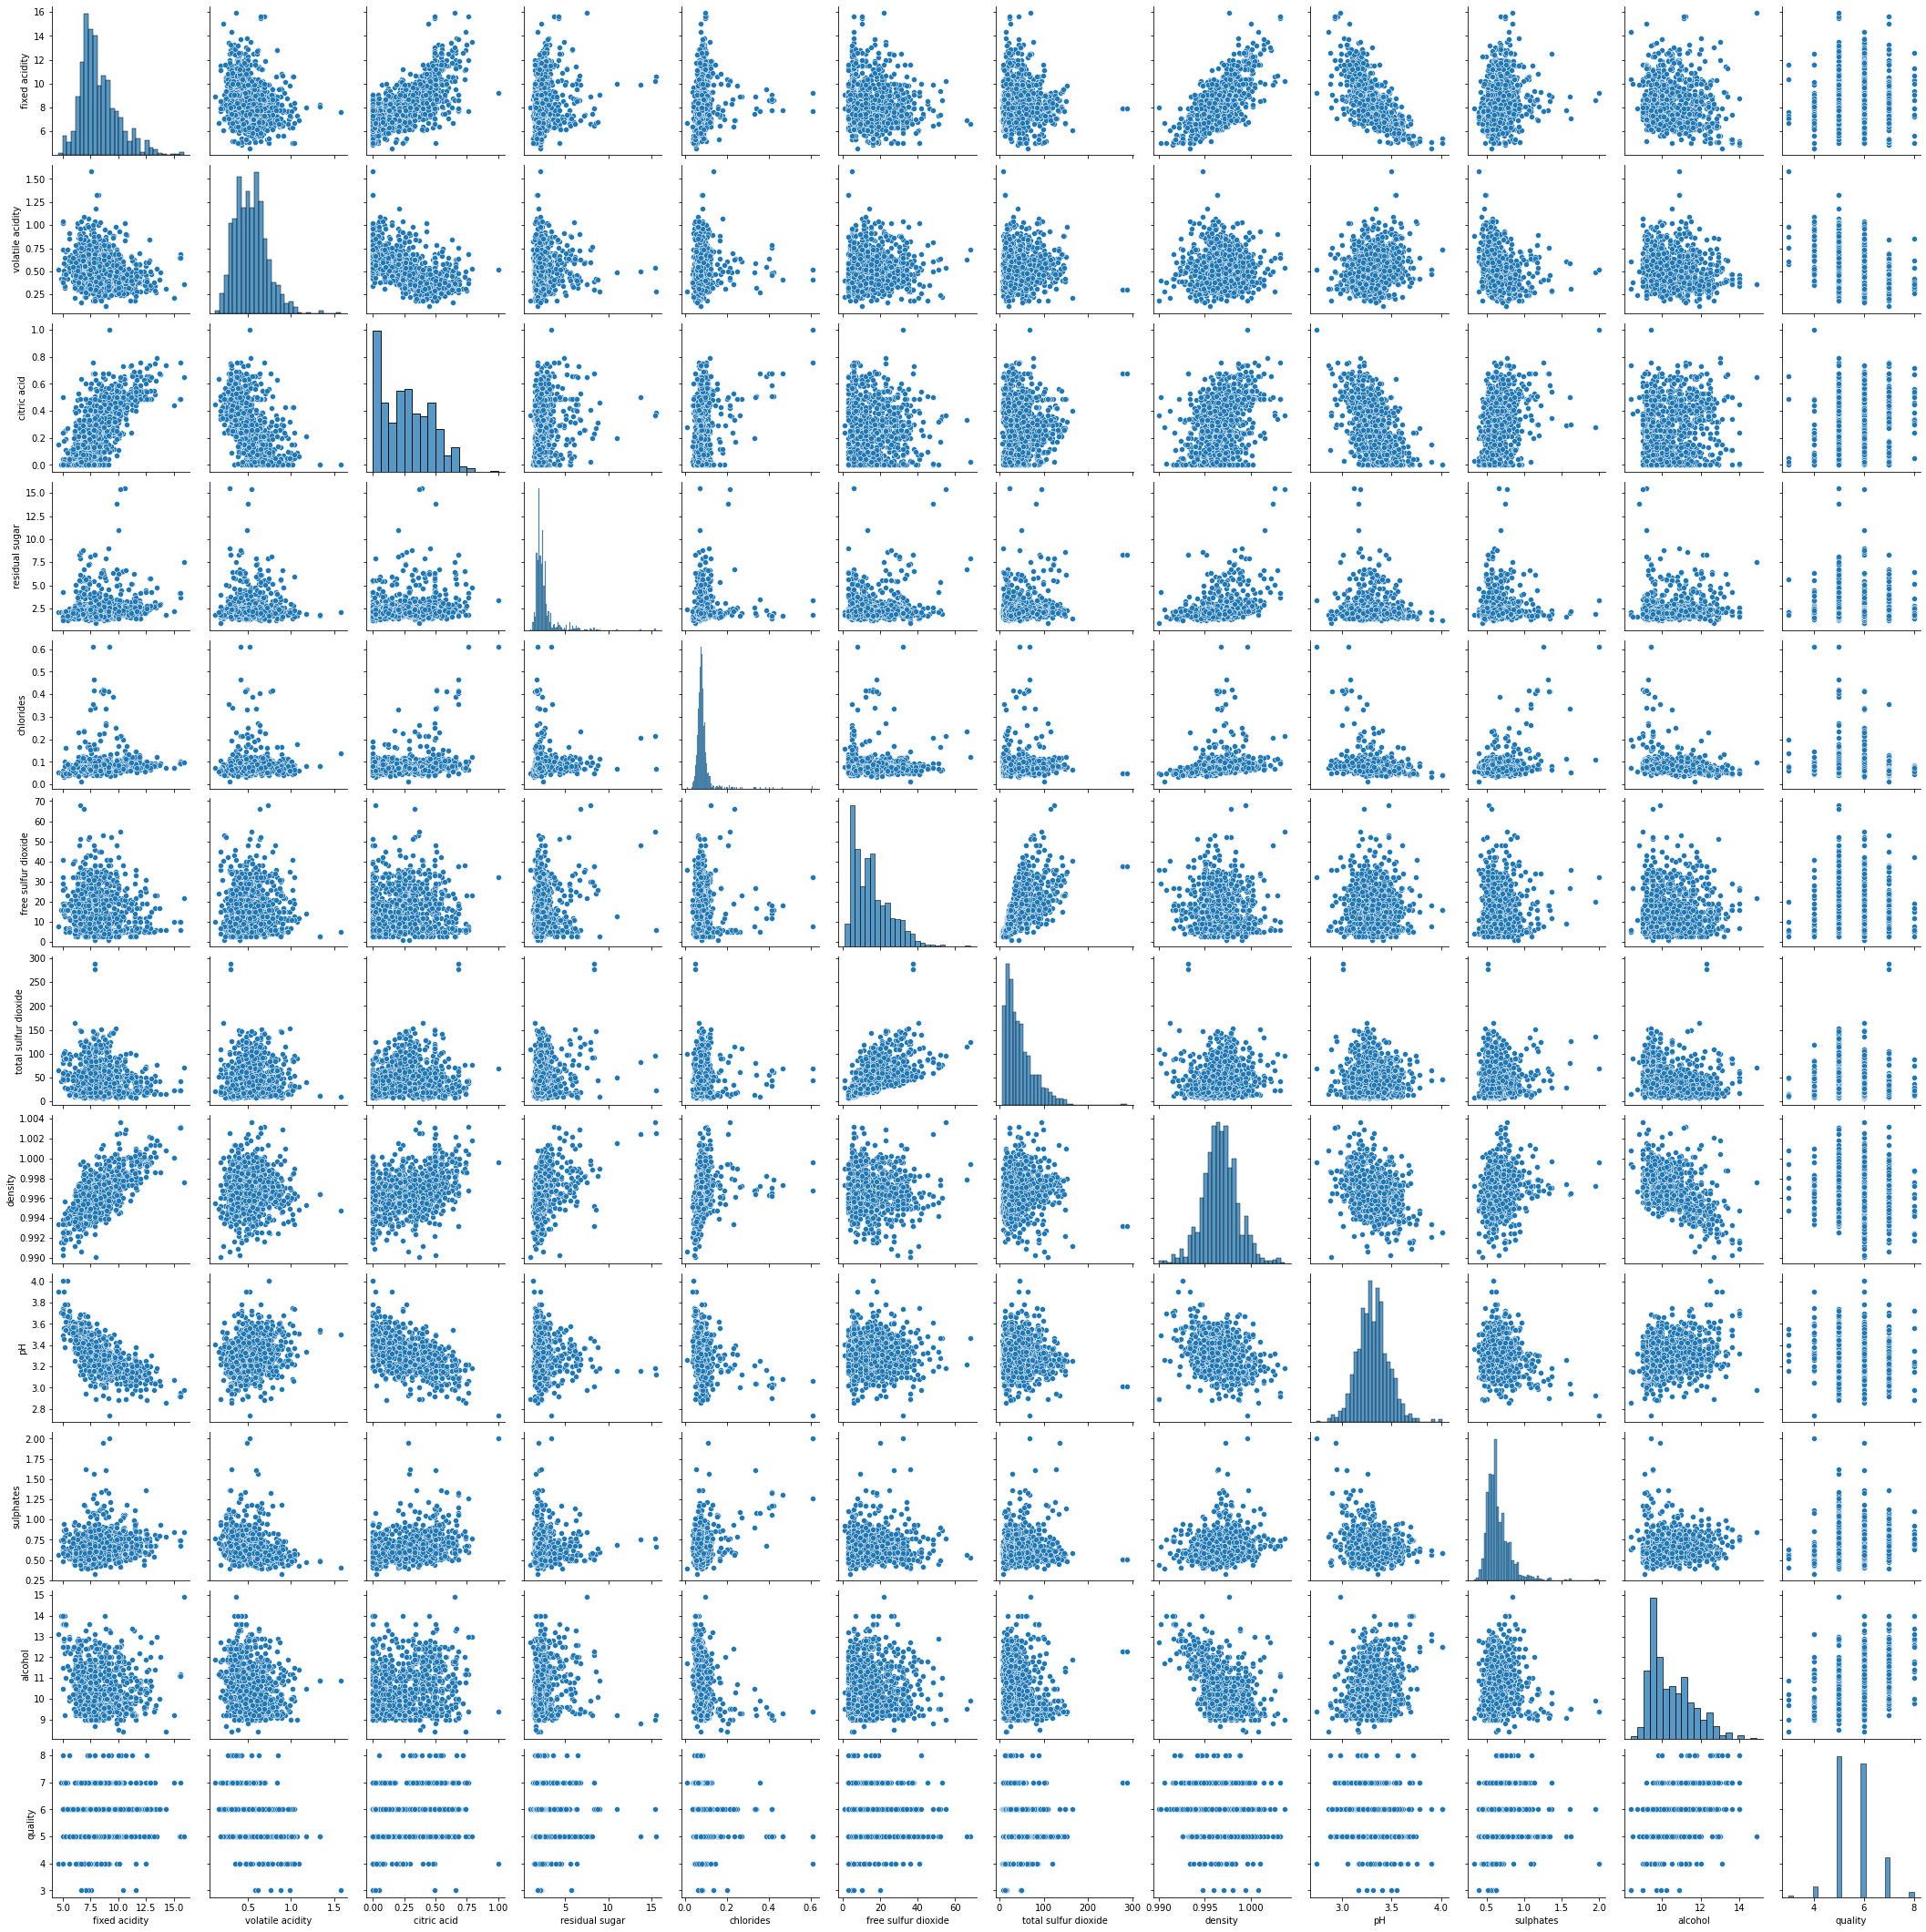

In [7]:
#showing pairplot
sns.pairplot(dataset)

<AxesSubplot:>

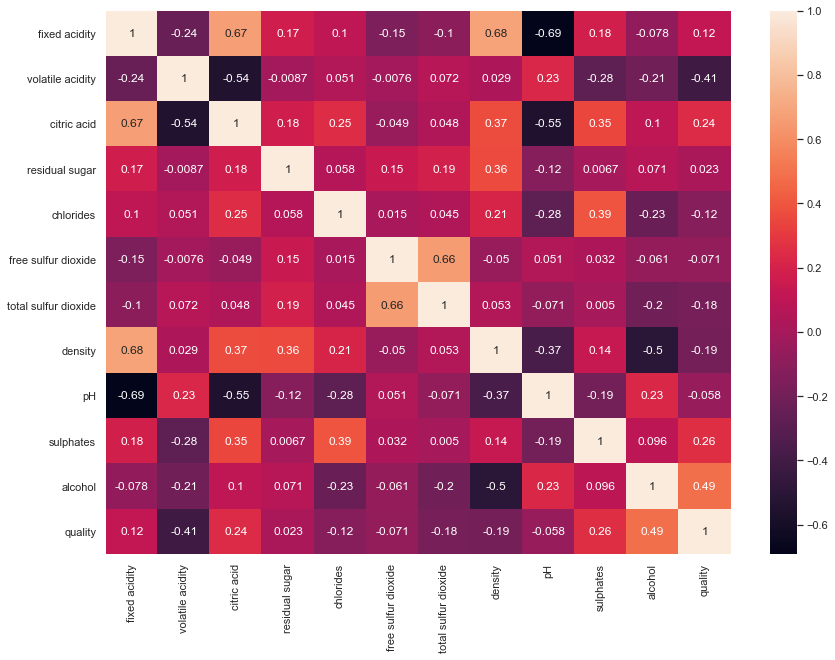

In [8]:
#plotting correlation heatmap
correlation = dataset.corr()
sns.set(rc={'figure.figsize':(14,10)})
sns.heatmap(correlation,
           annot=True)

Text(0, 0.5, 'Feature')

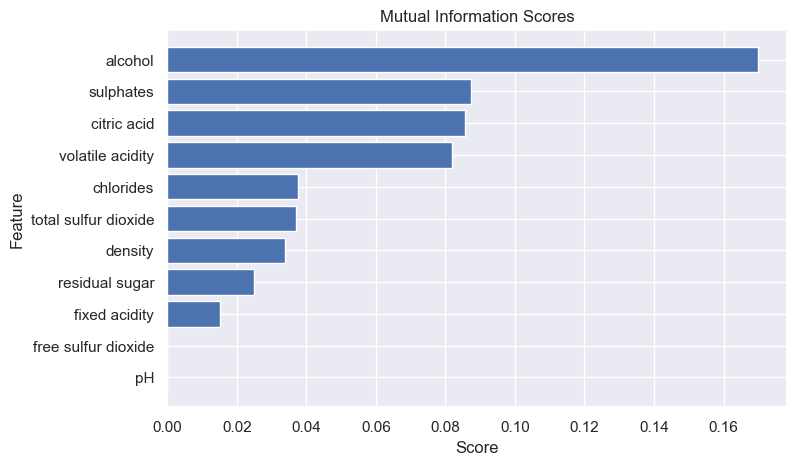

In [9]:
#there's many features that has low correlation with quality, so we gonna check features importance

#split data to features and target
X = dataset.drop("quality",axis=1)
y = dataset["quality"]

#import package for make mutual information scores
from sklearn.feature_selection import mutual_info_regression

#mutualinfo scores
mi = mutual_info_regression(X, y, discrete_features=False)
mi = pd.Series(mi, name="MI Scores", index=X.columns)
mi = mi.sort_values(ascending=False)

#plotting mutual information scores
plt.figure(dpi=100, figsize=(8, 5))
plt.barh(np.arange(len(mi.sort_values(ascending=True))), mi.sort_values(ascending=True))
plt.title("Mutual Information Scores")
plt.xlabel("Score")
plt.yticks(np.arange(len(mi.sort_values(ascending=True))), list(mi.sort_values(ascending=True).index))
plt.ylabel("Feature")

In [10]:
#dropping some columns with low mi scores
X = X.drop(["free sulfur dioxide","residual sugar","pH","fixed acidity","density"],axis=1)

#check X columns
X.columns

Index(['volatile acidity', 'citric acid', 'chlorides', 'total sulfur dioxide',
       'sulphates', 'alcohol'],
      dtype='object')

In [11]:
#splitting model to train and validation data
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, 
                                                  y, 
                                                  test_size=0.1, 
                                                  random_state=42)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(916, 6) (102, 6) (916,) (102,)


In [12]:
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train).astype('int32')
y_val = np_utils.to_categorical(y_val).astype('int32')

In [13]:
# determine the number of input features
n_features = X_train.shape[1]
print(n_features)

6


In [42]:
#define model
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,BatchNormalization, Flatten

model = Sequential()
model.add(Dense(64, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model.add(BatchNormalization()),
model.add(Dense(32, activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization()),
model.add(Flatten())
model.add(Dense(9, activation='softmax'))

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 64)                448       
                                                                 
 batch_normalization_4 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_24 (Dense)            (None, 32)                2080      
                                                                 
 batch_normalization_5 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 flatten_5 (Flatten)         (None, 32)                0         
                                                                 
 dense_25 (Dense)            (None, 9)                

In [43]:
#compile model
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [44]:
#define callbacks
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') > 0.99):
            print("Stop training!")
            self.model.stop_training = True
            
callbacks = myCallback()

In [45]:
#model fitting
history = model.fit(X_train,
                    y_train,
                    epochs=500,
                    validation_data=(X_val,y_val),
                    callbacks=[callbacks])

Epoch 1/500
29/29 [==============================] - 1s 9ms/step - loss: 2.1044 - accuracy: 0.2566 - val_loss: 4.8326 - val_accuracy: 0.0490
Epoch 2/500
29/29 [==============================] - 0s 3ms/step - loss: 1.7974 - accuracy: 0.4487 - val_loss: 4.5278 - val_accuracy: 0.0686
Epoch 3/500
29/29 [==============================] - 0s 3ms/step - loss: 1.6383 - accuracy: 0.5044 - val_loss: 3.7061 - val_accuracy: 0.0882
Epoch 4/500
29/29 [==============================] - 0s 3ms/step - loss: 1.5406 - accuracy: 0.5469 - val_loss: 3.3673 - val_accuracy: 0.1275
Epoch 5/500
29/29 [==============================] - 0s 3ms/step - loss: 1.4678 - accuracy: 0.5513 - val_loss: 2.8519 - val_accuracy: 0.2451
Epoch 6/500
29/29 [==============================] - 0s 3ms/step - loss: 1.3455 - accuracy: 0.5688 - val_loss: 2.3629 - val_accuracy: 0.3529
Epoch 7/500
29/29 [==============================] - 0s 3ms/step - loss: 1.2958 - accuracy: 0.5590 - val_loss: 2.2227 - val_accuracy: 0.3137
Epoch 8/500
2

Epoch 59/500
29/29 [==============================] - 0s 3ms/step - loss: 0.8769 - accuracy: 0.6212 - val_loss: 1.2565 - val_accuracy: 0.5196
Epoch 60/500
29/29 [==============================] - 0s 3ms/step - loss: 0.8749 - accuracy: 0.6310 - val_loss: 1.2304 - val_accuracy: 0.5000
Epoch 61/500
29/29 [==============================] - 0s 3ms/step - loss: 0.8683 - accuracy: 0.6310 - val_loss: 1.2610 - val_accuracy: 0.5196
Epoch 62/500
29/29 [==============================] - 0s 3ms/step - loss: 0.8702 - accuracy: 0.6059 - val_loss: 1.1893 - val_accuracy: 0.5294
Epoch 63/500
29/29 [==============================] - 0s 2ms/step - loss: 0.8761 - accuracy: 0.6266 - val_loss: 1.2249 - val_accuracy: 0.4804
Epoch 64/500
29/29 [==============================] - 0s 3ms/step - loss: 0.8720 - accuracy: 0.6288 - val_loss: 1.2620 - val_accuracy: 0.5196
Epoch 65/500
29/29 [==============================] - 0s 3ms/step - loss: 0.8714 - accuracy: 0.6190 - val_loss: 1.1932 - val_accuracy: 0.5294
Epoch 

29/29 [==============================] - 0s 3ms/step - loss: 0.8318 - accuracy: 0.6376 - val_loss: 1.2011 - val_accuracy: 0.5098
Epoch 117/500
29/29 [==============================] - 0s 3ms/step - loss: 0.8530 - accuracy: 0.6310 - val_loss: 1.2598 - val_accuracy: 0.5196
Epoch 118/500
29/29 [==============================] - 0s 3ms/step - loss: 0.8225 - accuracy: 0.6397 - val_loss: 1.2571 - val_accuracy: 0.5098
Epoch 119/500
29/29 [==============================] - 0s 3ms/step - loss: 0.8498 - accuracy: 0.6201 - val_loss: 1.3296 - val_accuracy: 0.4608
Epoch 120/500
29/29 [==============================] - 0s 3ms/step - loss: 0.8549 - accuracy: 0.6376 - val_loss: 1.1934 - val_accuracy: 0.5196
Epoch 121/500
29/29 [==============================] - 0s 3ms/step - loss: 0.8464 - accuracy: 0.6212 - val_loss: 1.1830 - val_accuracy: 0.5098
Epoch 122/500
29/29 [==============================] - 0s 3ms/step - loss: 0.8650 - accuracy: 0.6201 - val_loss: 1.2083 - val_accuracy: 0.5392
Epoch 123/500

29/29 [==============================] - 0s 3ms/step - loss: 0.8282 - accuracy: 0.6310 - val_loss: 1.2163 - val_accuracy: 0.5294
Epoch 174/500
29/29 [==============================] - 0s 2ms/step - loss: 0.8269 - accuracy: 0.6354 - val_loss: 1.1945 - val_accuracy: 0.5294
Epoch 175/500
29/29 [==============================] - 0s 3ms/step - loss: 0.8284 - accuracy: 0.6321 - val_loss: 1.1591 - val_accuracy: 0.5196
Epoch 176/500
29/29 [==============================] - 0s 3ms/step - loss: 0.8225 - accuracy: 0.6408 - val_loss: 1.2184 - val_accuracy: 0.5294
Epoch 177/500
29/29 [==============================] - 0s 3ms/step - loss: 0.8392 - accuracy: 0.6332 - val_loss: 1.2216 - val_accuracy: 0.5098
Epoch 178/500
29/29 [==============================] - 0s 3ms/step - loss: 0.8199 - accuracy: 0.6463 - val_loss: 1.2487 - val_accuracy: 0.4902
Epoch 179/500
29/29 [==============================] - 0s 3ms/step - loss: 0.8240 - accuracy: 0.6430 - val_loss: 1.2360 - val_accuracy: 0.5098
Epoch 180/500

29/29 [==============================] - 0s 3ms/step - loss: 0.8252 - accuracy: 0.6310 - val_loss: 1.2464 - val_accuracy: 0.5196
Epoch 231/500
29/29 [==============================] - 0s 3ms/step - loss: 0.8147 - accuracy: 0.6354 - val_loss: 1.2209 - val_accuracy: 0.5098
Epoch 232/500
29/29 [==============================] - 0s 2ms/step - loss: 0.8128 - accuracy: 0.6528 - val_loss: 1.2603 - val_accuracy: 0.5196
Epoch 233/500
29/29 [==============================] - 0s 3ms/step - loss: 0.8106 - accuracy: 0.6408 - val_loss: 1.2652 - val_accuracy: 0.5294
Epoch 234/500
29/29 [==============================] - 0s 3ms/step - loss: 0.8233 - accuracy: 0.6408 - val_loss: 1.2687 - val_accuracy: 0.5294
Epoch 235/500
29/29 [==============================] - 0s 2ms/step - loss: 0.8108 - accuracy: 0.6507 - val_loss: 1.2516 - val_accuracy: 0.5000
Epoch 236/500
29/29 [==============================] - 0s 2ms/step - loss: 0.8102 - accuracy: 0.6528 - val_loss: 1.2456 - val_accuracy: 0.5490
Epoch 237/500

29/29 [==============================] - 0s 2ms/step - loss: 0.8077 - accuracy: 0.6474 - val_loss: 1.4283 - val_accuracy: 0.5392
Epoch 288/500
29/29 [==============================] - 0s 3ms/step - loss: 0.7995 - accuracy: 0.6419 - val_loss: 1.3717 - val_accuracy: 0.5000
Epoch 289/500
29/29 [==============================] - 0s 3ms/step - loss: 0.7995 - accuracy: 0.6452 - val_loss: 1.3841 - val_accuracy: 0.5196
Epoch 290/500
29/29 [==============================] - 0s 3ms/step - loss: 0.8101 - accuracy: 0.6397 - val_loss: 1.2846 - val_accuracy: 0.5392
Epoch 291/500
29/29 [==============================] - 0s 3ms/step - loss: 0.8004 - accuracy: 0.6528 - val_loss: 1.2707 - val_accuracy: 0.5392
Epoch 292/500
29/29 [==============================] - 0s 3ms/step - loss: 0.8093 - accuracy: 0.6343 - val_loss: 1.2950 - val_accuracy: 0.5294
Epoch 293/500
29/29 [==============================] - 0s 3ms/step - loss: 0.8055 - accuracy: 0.6507 - val_loss: 1.2660 - val_accuracy: 0.5588
Epoch 294/500

29/29 [==============================] - 0s 3ms/step - loss: 0.8018 - accuracy: 0.6605 - val_loss: 1.2630 - val_accuracy: 0.5294
Epoch 345/500
29/29 [==============================] - 0s 3ms/step - loss: 0.7839 - accuracy: 0.6528 - val_loss: 1.3113 - val_accuracy: 0.5392
Epoch 346/500
29/29 [==============================] - 0s 2ms/step - loss: 0.8153 - accuracy: 0.6288 - val_loss: 1.2472 - val_accuracy: 0.5196
Epoch 347/500
29/29 [==============================] - 0s 3ms/step - loss: 0.7896 - accuracy: 0.6583 - val_loss: 1.3259 - val_accuracy: 0.5098
Epoch 348/500
29/29 [==============================] - 0s 3ms/step - loss: 0.7697 - accuracy: 0.6550 - val_loss: 1.2923 - val_accuracy: 0.5196
Epoch 349/500
29/29 [==============================] - 0s 3ms/step - loss: 0.7897 - accuracy: 0.6550 - val_loss: 1.3251 - val_accuracy: 0.5784
Epoch 350/500
29/29 [==============================] - 0s 2ms/step - loss: 0.7969 - accuracy: 0.6365 - val_loss: 1.3698 - val_accuracy: 0.4804
Epoch 351/500

29/29 [==============================] - 0s 3ms/step - loss: 0.7841 - accuracy: 0.6572 - val_loss: 1.4042 - val_accuracy: 0.5098
Epoch 402/500
29/29 [==============================] - 0s 3ms/step - loss: 0.7745 - accuracy: 0.6572 - val_loss: 1.4181 - val_accuracy: 0.5196
Epoch 403/500
29/29 [==============================] - 0s 3ms/step - loss: 0.7622 - accuracy: 0.6496 - val_loss: 1.3603 - val_accuracy: 0.5196
Epoch 404/500
29/29 [==============================] - 0s 4ms/step - loss: 0.7767 - accuracy: 0.6583 - val_loss: 1.3025 - val_accuracy: 0.5294
Epoch 405/500
29/29 [==============================] - 0s 3ms/step - loss: 0.7668 - accuracy: 0.6670 - val_loss: 1.3287 - val_accuracy: 0.5490
Epoch 406/500
29/29 [==============================] - 0s 3ms/step - loss: 0.7640 - accuracy: 0.6758 - val_loss: 1.3797 - val_accuracy: 0.5098
Epoch 407/500
29/29 [==============================] - 0s 3ms/step - loss: 0.7655 - accuracy: 0.6648 - val_loss: 1.3222 - val_accuracy: 0.5588
Epoch 408/500

29/29 [==============================] - 0s 3ms/step - loss: 0.7772 - accuracy: 0.6605 - val_loss: 1.3659 - val_accuracy: 0.5098
Epoch 459/500
29/29 [==============================] - 0s 3ms/step - loss: 0.7912 - accuracy: 0.6692 - val_loss: 1.3752 - val_accuracy: 0.5294
Epoch 460/500
29/29 [==============================] - 0s 3ms/step - loss: 0.7774 - accuracy: 0.6485 - val_loss: 1.3634 - val_accuracy: 0.5196
Epoch 461/500
29/29 [==============================] - 0s 3ms/step - loss: 0.7582 - accuracy: 0.6703 - val_loss: 1.3363 - val_accuracy: 0.5490
Epoch 462/500
29/29 [==============================] - 0s 3ms/step - loss: 0.7593 - accuracy: 0.6463 - val_loss: 1.3462 - val_accuracy: 0.5196
Epoch 463/500
29/29 [==============================] - 0s 3ms/step - loss: 0.7655 - accuracy: 0.6648 - val_loss: 1.3775 - val_accuracy: 0.5588
Epoch 464/500
29/29 [==============================] - 0s 3ms/step - loss: 0.7802 - accuracy: 0.6572 - val_loss: 1.3463 - val_accuracy: 0.5784
Epoch 465/500

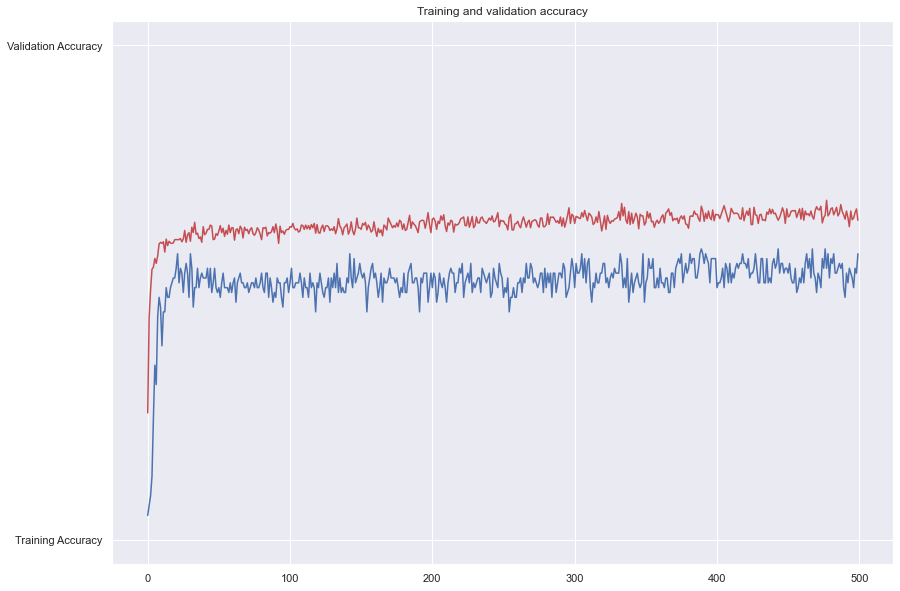

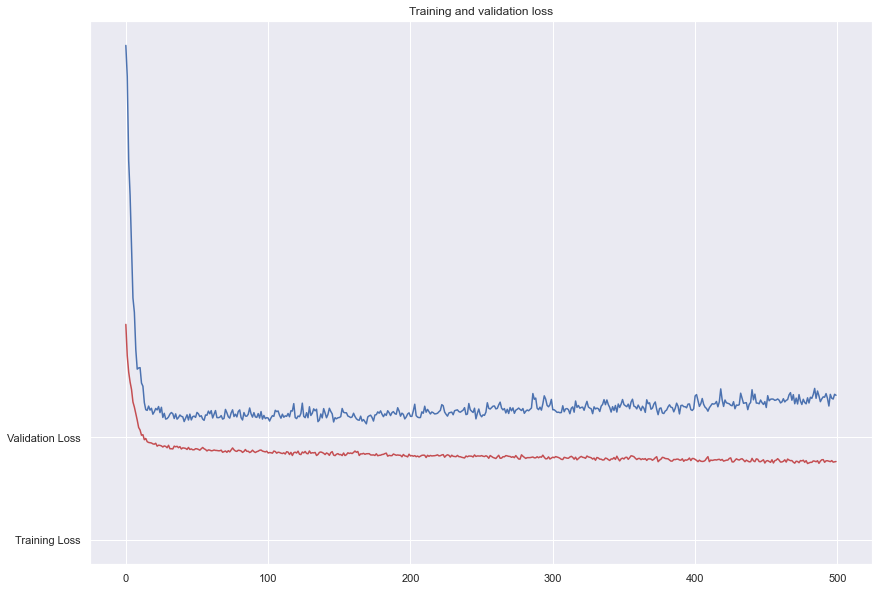

In [47]:
#training plot
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.title('Training and validation loss')
plt.show()